In [1]:
import numpy as np
import pandas as pd

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
train_df.shape

(7500, 17)

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [9]:
test_df.shape

(2500, 16)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [12]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

# БАЗОВОЕ РЕШЕНИЕ

In [13]:
train_df['Annual Income'].median()

1168386.0

In [14]:
train_df['Years in current job'].mode()

0    10+ years
dtype: object

In [15]:
train_df['Months since last delinquent'].median()

32.0

In [16]:
train_df['Bankruptcies'].mode()

0    0.0
dtype: float64

In [17]:
train_df['Credit Score'].median()

731.0

In [18]:
train_df_base_solution = train_df.copy()
train_df_base_solution.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


#### заполнение количественных признаков медианами для базового решения

In [19]:
train_df_base_solution['Annual Income'] =\
    train_df_base_solution['Annual Income'].fillna(train_df_base_solution['Annual Income'].median())

train_df_base_solution['Months since last delinquent'] =\
    train_df_base_solution['Months since last delinquent'].fillna(train_df_base_solution['Months since last delinquent'].median())

train_df_base_solution['Credit Score'] =\
    train_df_base_solution['Credit Score'].fillna(train_df_base_solution['Credit Score'].median())

In [20]:
print(train_df_base_solution['Annual Income'].isna().sum())
print(train_df_base_solution['Months since last delinquent'].isna().sum())
print(train_df_base_solution['Credit Score'].isna().sum())

0
0
0


#### заполнение категориальных признаков модами для базового решения

In [21]:
train_df_base_solution['Years in current job'] =\
    train_df_base_solution['Years in current job'].fillna(train_df_base_solution['Years in current job'].mode()[0])
train_df_base_solution['Bankruptcies'] =\
    train_df_base_solution['Bankruptcies'].fillna(train_df_base_solution['Bankruptcies'].mode()[0])

In [22]:
print(train_df_base_solution['Years in current job'].isna().sum())
print(train_df_base_solution['Bankruptcies'].isna().sum())

0
0


#### проверка на отсутствие пропусков в датафрейме для базового решения

In [23]:
train_df_base_solution.isna().sum().sum()

0

In [24]:
train_df_base_solution.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

#### получение get_dummies для категориальных переменных и удаление переменной из которой делали get_dummies

In [25]:
list_of_features_to_get_dummies = ['Home Ownership',
                                   'Years in current job',
                                   'Purpose', 
                                   'Term']

for feature in list_of_features_to_get_dummies:
    # получение get_dummies
    train_df_base_solution = pd.concat([train_df_base_solution, 
                                        pd.get_dummies(pd.get_dummies(train_df_base_solution[feature],
                                        prefix=feature))],
                                        axis=1)
    # удаление признака
    train_df_base_solution = train_df_base_solution.drop([feature], axis=1)

In [26]:
train_df_base_solution.dtypes

Annual Income                     float64
Tax Liens                         float64
Number of Open Accounts           float64
Years of Credit History           float64
Maximum Open Credit               float64
Number of Credit Problems         float64
Months since last delinquent      float64
Bankruptcies                      float64
Current Loan Amount               float64
Current Credit Balance            float64
Monthly Debt                      float64
Credit Score                      float64
Credit Default                      int64
Home Ownership_Have Mortgage        uint8
Home Ownership_Home Mortgage        uint8
Home Ownership_Own Home             uint8
Home Ownership_Rent                 uint8
Years in current job_1 year         uint8
Years in current job_10+ years      uint8
Years in current job_2 years        uint8
Years in current job_3 years        uint8
Years in current job_4 years        uint8
Years in current job_5 years        uint8
Years in current job_6 years      

#### Разбиение на train и test

In [27]:
TARGET_NAME = 'Credit Default'

X = train_df_base_solution.drop(TARGET_NAME, axis=1)
y = train_df_base_solution[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

#### Масштабрование данных

In [28]:
scaler = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm = scaler.fit_transform(X_train_norm)
X_test_norm = scaler.transform(X_test_norm)

In [29]:
model_lr = LogisticRegression()
model_lr.fit(X_train_norm, y_train)

evaluate_preds(model_lr, X_train_norm, X_test_norm, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.97      0.86      3771
           1       0.81      0.29      0.43      1479

    accuracy                           0.78      5250
   macro avg       0.80      0.63      0.65      5250
weighted avg       0.79      0.78      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1616
           1       0.77      0.25      0.38       634

    accuracy                           0.77      2250
   macro avg       0.77      0.61      0.62      2250
weighted avg       0.77      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1569   47
1                474  160


In [30]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.55},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3771
           1       0.53      0.51      0.52      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.67      0.67      5250
weighted avg       0.73      0.73      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1616
           1       0.51      0.49      0.50       634

    accuracy                           0.72      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1312  304
1                322  312


# f1-score на TEST на базовом решении 0.65!!!

# EDA

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [31]:
train_df.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0


In [32]:
train_df.shape

(7500, 17)

In [33]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [34]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### составление списков числовых и категориальных переменных

In [36]:
print('\nчисловые переменные:\n', train_df.select_dtypes(np.number).columns.to_list())
print('\nкатегориальные переменные:\n', train_df.select_dtypes(np.object).columns.to_list())


числовые переменные:
 ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Credit Default']

категориальные переменные:
 ['Home Ownership', 'Years in current job', 'Purpose', 'Term']


In [142]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
                      'Number of Open Accounts', 'Years of Credit History',
                      'Maximum Open Credit', 'Number of Credit Problems',
                      'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
                      'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                      'Credit Score']

NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 
                     'Years of Credit History', 'Maximum Open Credit', 
                     'Months since last delinquent', 
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 
                     'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems']

### Целевая переменная - Credit Default

#### Баланс классов целевой переменной

In [38]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Корреляция целевой переменной с базовыми признаками

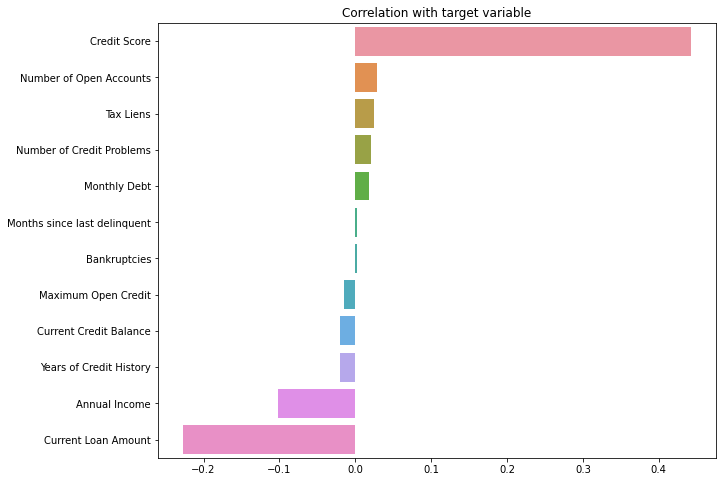

In [39]:
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Home Ownership / домовладение

In [40]:
train_df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

#### целесообразно написать функцию по созданию dummy переменных из категорий признака

In [41]:
def generate_dummies_from_home_ownership(X):
    X['G_home_ownership_home_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Home Mortgage', 'G_home_ownership_home_mortgage'] = 1
    
    X['G_home_ownership_rent'] = 0
    X.loc[X['Home Ownership'] == 'Rent', 'G_home_ownership_rent'] = 1
    
    X['G_home_ownership_own_home'] = 0
    X.loc[X['Home Ownership'] == 'Own Home', 'G_home_ownership_own_home'] = 1
    
    X['G_home_ownership_have_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Have Mortgage', 'G_home_ownership_have_mortgage'] = 1
    
    X['G_home_ownership_other'] = 0
    X.loc[~X['Home Ownership'].isin(['Home Mortgage', 'Rent', 'Own Home', 'Have Mortgage']), 'G_home_ownership_other'] = 1
    
    return X

#### проверка согласованности частот Home Ownership в разрезе целевой переменной используя Хи-квадрат Пирсона

*напишем функцию которая будет проверять согласованность частот любого категориального признака при помощи хи квадрата Пирсона*

In [165]:
def check_frequencies_match_of_a_categorical_feature_with_chi2(df, feature_name, target_name):
    
    # создание копии принимаемого датафрейма, функция не вносит никаких изменений в данные
    X = df.copy()
    
    # создание поля индекса для удобности подсчёта в pivot_table... aggfunc='count'
    X['Id'] = X.index
    
    # создание списка категорий признака
    list_of_categories = list(df[feature_name].unique())
    print('\nlist of categories:\n', list_of_categories)
    
    # создание списка уникальных пар категорий признака
    list_of_categories_pairs = [list(i) for i in list(itertools.combinations(list_of_categories, 2))]
#     print('\nlist_of_categories_pairs:\n', list_of_categories_pairs)
    
    # рассчёт p-value для хи квадрата для каждой пары из списка уникальных пар категорий признака
    df_of_categories_pairs_with_chi2_p_value = pd.DataFrame()
    for categories_pair in list_of_categories_pairs:
        feature_and_target = X.loc[df[feature_name].isin(categories_pair), ['Id', feature_name, target_name]]
        table = feature_and_target.pivot_table(values='Id', index=feature_name, columns=target_name, aggfunc='count')
#         print('\ntable:\n', table)

        chi2, p, _, _ = chi2_contingency(table)
        
        try:
            category_1_proportion_of_0 = table[0][categories_pair[0]]
        except:
            category_1_proportion_of_0 = None
        try:
            category_1_proportion_of_1 = table[1][categories_pair[0]]
        except:
            category_1_proportion_of_1 = None
        try:
            category_2_proportion_of_0 = table[0][categories_pair[1]]
        except:
            category_2_proportion_of_0 = None
        try:
            category_2_proportion_of_1 = table[1][categories_pair[1]]
        except:
            category_2_proportion_of_1 = None       
        
        # запись строки в парами и p-value в датафрейм
        df_of_categories_pairs_with_chi2_p_value = df_of_categories_pairs_with_chi2_p_value.append({
            'cat_1': categories_pair[0],
            'cat_2': categories_pair[1],
            'cat_1_prop_of_0_and_1': f'{category_1_proportion_of_0} : {category_1_proportion_of_1}',
            'cat_2_prop_of_0_and_1': f'{category_2_proportion_of_0} : {category_2_proportion_of_1}',
            'cat_1_prop_of_1': 
                f'{round(category_1_proportion_of_1 / (category_1_proportion_of_0 + category_1_proportion_of_1), 2)}',
            'cat_2_prop_of_1': 
                f'{round(category_2_proportion_of_1 / (category_2_proportion_of_0 + category_2_proportion_of_1), 2)}',
            'chi2_p_val': round(p, 3),
            'chi2_p_val_>_alpha': True if p > 0.05 else False
        }, ignore_index=True)

    return df_of_categories_pairs_with_chi2_p_value

посмотрим результат работы функции check_frequencies_match_of_a_categorical_feature_with_chi2 рассчитав согласованность частот признака Home Ownership в разрезе целевой переменной

In [121]:
df = train_df.copy()
check_frequencies_match_of_a_categorical_feature_with_chi2(df, feature_name='Home Ownership', target_name=TARGET_NAME)


list of categories:
 ['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']


,category_1,category_1_proportions_of_0_and_1,category_2,category_2_proportions_of_0_and_1,chi2_p_value,chi2_p_value_more_than_alpha
0,Own Home,455 : 192,Home Mortgage,2721 : 916,0.019,0.0
1,Own Home,455 : 192,Rent,2201 : 1003,0.441,1.0
2,Own Home,455 : 192,Have Mortgage,10 : 2,0.509,1.0
3,Home Mortgage,2721 : 916,Rent,2201 : 1003,0.000,0.0
4,Home Mortgage,2721 : 916,Have Mortgage,10 : 2,0.730,1.0
5,Rent,2201 : 1003,Have Mortgage,10 : 2,0.435,1.0


#### построим график распределения частот Home Ownership для наглядности

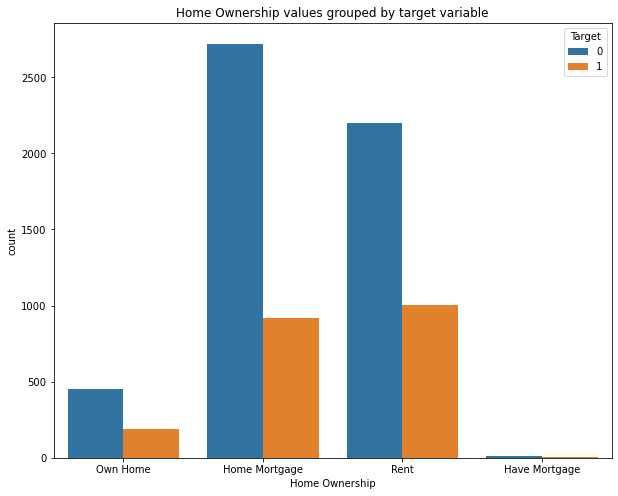

In [44]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=train_df)
plt.title('Home Ownership values grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Наблюдения:

    - Own Home, Rent и Have Mortgage согласованы.
    - Home Mortgage и Have Mortgage также согласованы.
    - Согласованность Have Mortgage со всеми другими категориями группы вероятно объясняется малым количеством объектов этой категории.
Идеи:

    - Создать новый бинарный признак G_home_ownership_reduced_to_2_categories путём сокращения признака Home Ownership до 2х категорий. При этом категорию Have Mortgage объединить с категорией Home Mortgage в виду большего значения p-value.

#### напишем функцию по созданию нового бинарного признака G_home_ownership_reduced_to_binary путём сокращения признака Home Ownership до 2х категорий

In [45]:
def generate_G_home_ownership_reduced_to_binary(X):
    X['G_home_ownership_reduced_to_binary'] = 0
    X.loc[~X['Home Ownership'].isin(['Own Home', 'Rent']), 'G_home_ownership_reduced_to_binary'] = 1
    return X

Итого, по признаку Home Ownership созданы механизмы как по генерации dummy-признаков из категорий оригинального признака, так и создания нового бинарного признака путём объединения категорий оригинального признака с согласованными по хи квадрату Пирсона частотами в две категории. 

### Years in current job / количество лет на текущем месте работы

посмотрим на количество пропусков в признаке

In [46]:
train_df['Years in current job'].isna().value_counts()

False    7129
True      371
Name: Years in current job, dtype: int64

есть пропуски

посмотрим на категории признака

In [47]:
train_df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

#### Рассчитаем согласованность частот признака Years in current job в разрезе целевой переменной при помощи функции check_frequencies_match_of_a_categorical_feature_with_chi2, при этом пропуски в признаке выделим в дополнительную категорию 

In [48]:
df = train_df.copy()
df['Years in current job'] = df['Years in current job'].fillna(value='not_indicated')

pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Years in current job', target_name=TARGET_NAME)


list of categories:
 ['not_indicated', '10+ years', '8 years', '6 years', '7 years', '5 years', '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years']

list_of_categories_pairs:
 [['not_indicated', '10+ years'], ['not_indicated', '8 years'], ['not_indicated', '6 years'], ['not_indicated', '7 years'], ['not_indicated', '5 years'], ['not_indicated', '1 year'], ['not_indicated', '< 1 year'], ['not_indicated', '4 years'], ['not_indicated', '3 years'], ['not_indicated', '2 years'], ['not_indicated', '9 years'], ['10+ years', '8 years'], ['10+ years', '6 years'], ['10+ years', '7 years'], ['10+ years', '5 years'], ['10+ years', '1 year'], ['10+ years', '< 1 year'], ['10+ years', '4 years'], ['10+ years', '3 years'], ['10+ years', '2 years'], ['10+ years', '9 years'], ['8 years', '6 years'], ['8 years', '7 years'], ['8 years', '5 years'], ['8 years', '1 year'], ['8 years', '< 1 year'], ['8 years', '4 years'], ['8 years', '3 years'], ['8 years', '2 years'], ['8 years', '9 years'], 

,category_1,category_1_proportions_of_0_and_1,category_2,category_2_proportions_of_0_and_1,chi2_p_value,chi2_p_value_more_than_alpha
0,not_indicated,234 : 137,10+ years,1688 : 644,0.000,0.0
1,not_indicated,234 : 137,8 years,247 : 92,0.007,0.0
2,not_indicated,234 : 137,6 years,302 : 124,0.023,0.0
3,not_indicated,234 : 137,7 years,285 : 111,0.011,0.0
4,not_indicated,234 : 137,5 years,371 : 145,0.007,0.0
5,not_indicated,234 : 137,1 year,362 : 142,0.008,0.0
6,not_indicated,234 : 137,< 1 year,404 : 159,0.007,0.0
7,not_indicated,234 : 137,4 years,338 : 131,0.007,0.0
8,not_indicated,234 : 137,3 years,450 : 170,0.002,0.0
9,not_indicated,234 : 137,2 years,512 : 193,0.002,0.0


In [49]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Частоты всех категорий признака, кроме созданной вместо пропусков not_indicated, согласованы между собой.
    - В категории not_indicated в разрезе целевой переменной наблюдается значительный процент значений = 1, что значительно выше, чем в какой либо другой категории признака.
Идеи:

    - Создать новый бинарный признак G_years_in_current_job_reduced_to_2_categories путём сокращения признака Years in current job до 2х категорий: 1 - куда войдут все пропуски и 0 - все указаные категории.

#### напишем функцию по созданию нового бинарного признака G_years_in_current_job_reduced_to_binary путём сокращения признака Years in current job до 2х категорий

In [50]:
def generate_G_years_in_current_job_reduced_to_binary(X):
    X['G_years_in_current_job_reduced_to_binary'] = 0
    X.loc[X['Years in current job'].isna(), 'G_years_in_current_job_reduced_to_binary'] = 1
    return X

### Purpose / цель кредита

In [51]:
train_df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

#### рассчитаем согласованность частот признака Purpose в разрезе целевой переменной при помощи функции check_frequencies_match_of_a_categorical_feature_with_chi2

In [52]:
df = train_df.copy()

pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Purpose', target_name=TARGET_NAME)


list of categories:
 ['debt consolidation', 'other', 'home improvements', 'take a trip', 'buy a car', 'small business', 'business loan', 'wedding', 'educational expenses', 'buy house', 'medical bills', 'moving', 'major purchase', 'vacation', 'renewable energy']

list_of_categories_pairs:
 [['debt consolidation', 'other'], ['debt consolidation', 'home improvements'], ['debt consolidation', 'take a trip'], ['debt consolidation', 'buy a car'], ['debt consolidation', 'small business'], ['debt consolidation', 'business loan'], ['debt consolidation', 'wedding'], ['debt consolidation', 'educational expenses'], ['debt consolidation', 'buy house'], ['debt consolidation', 'medical bills'], ['debt consolidation', 'moving'], ['debt consolidation', 'major purchase'], ['debt consolidation', 'vacation'], ['debt consolidation', 'renewable energy'], ['other', 'home improvements'], ['other', 'take a trip'], ['other', 'buy a car'], ['other', 'small business'], ['other', 'business loan'], ['other', 'wedd

,category_1,category_1_proportions_of_0_and_1,category_2,category_2_proportions_of_0_and_1,chi2_p_value,chi2_p_value_more_than_alpha
0,debt consolidation,4290 : 1654,other,468 : 197,0.351,1.0
1,debt consolidation,4290 : 1654,home improvements,304 : 108,0.515,1.0
2,debt consolidation,4290 : 1654,take a trip,27 : 10,0.940,1.0
3,debt consolidation,4290 : 1654,buy a car,72 : 24,0.618,1.0
4,debt consolidation,4290 : 1654,small business,12 : 14,0.006,0.0
5,debt consolidation,4290 : 1654,business loan,74 : 55,0.000,0.0
6,debt consolidation,4290 : 1654,wedding,11 : 4,0.851,1.0
7,debt consolidation,4290 : 1654,educational expenses,9 : 1,0.366,1.0
8,debt consolidation,4290 : 1654,buy house,25 : 9,0.987,1.0
9,debt consolidation,4290 : 1654,medical bills,49 : 22,0.648,1.0


In [53]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Частоты признака по их согласованности и простой логике (где согласованности нет в виду очень малого количества объектов данной категории) можно разделить на 2 группы:
    1я: 'debt consolidation', 'other', 'home improvements', 
       'buy a car', 'medical bills', 'major purchase', 'take a trip',
       'buy house', 'small business', 'wedding', 'moving',
       'educational expenses', 'vacation', 'renewable energy'
    2я: 'business loan', 'small business'

Идеи:

    - Создать новый бинарный признак G_purpose_reduced_to_2_categories путём сокращения признака Purpose до 2х категорий.

#### напишем функцию по созданию нового бинарного признака G_purpose_reduced_to_binary путём сокращения признака Purpose до 2х категорий

In [54]:
def generate_G_purpose_reduced_to_binary(X):
    X['G_purpose_reduced_to_binary'] = 0
    X.loc[X['Purpose'].isin(['business loan', 'small business']), 'G_purpose_reduced_to_binary'] = 1
    return X

### Term / срок кредита

In [55]:
train_df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Наблюдения:

    - В признаке нет пропусков и всего 2 категории.
Идеи:

    - Создать новый бинарный признак G_term_transformed_to_binary путём замены строковых значений признака Term на 1 и 0.

#### напишем функцию по созданию нового бинарного признака G_term_transformed_to_binary путём трансформации значений признака Term в 0 и 1

In [56]:
def generate_G_term_transformed_to_binary(X):
    X['G_term_transformed_to_binary'] = 0
    X.loc[X['Term'] == 'Long Term', 'G_term_transformed_to_binary'] = 1
    return X

### Tax Liens / налоговые обременения

In [57]:
train_df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [58]:
test_df['Tax Liens'].value_counts()

0.0     2445
1.0       45
2.0        5
15.0       1
3.0        1
6.0        1
4.0        1
5.0        1
Name: Tax Liens, dtype: int64

#### проверка согласованности частот используя Хи-квадрат Пирсона

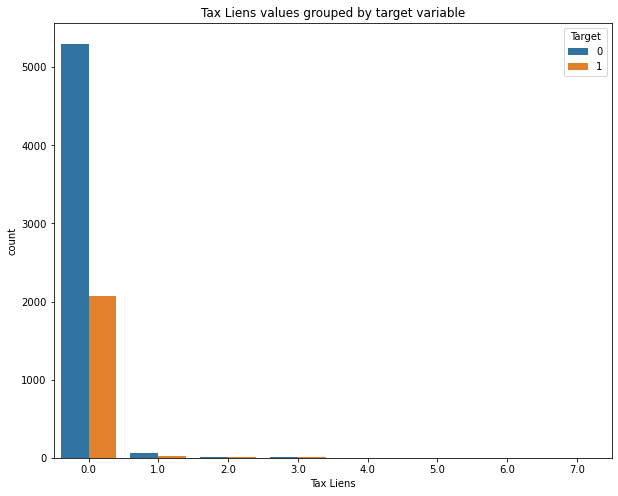

In [59]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Tax Liens", hue=TARGET_NAME, data=train_df)
plt.title('Tax Liens values grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

*проверка согласованности частот категорий 0 и 1*

In [60]:
df = train_df.copy()
variable_name = 'Tax Liens'
df['Id'] = df.index

In [61]:
variable_and_target = df.loc[df[variable_name].isin([0, 1]), ['Id', variable_name, TARGET_NAME]]
table = variable_and_target.pivot_table(values='Id', index=variable_name, columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
0.0,5301,2065
1.0,59,24


In [62]:
chi2, p, _, _ = chi2_contingency(table)
p

0.956212700856196

P-value получилось больше выбранного уровня значимости (0.05), соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории 0 и 1 одинаково влияют на целевую переменную и их можно объединить в одну категорию.

*проверка согласованности частот категорий 2, 3, 4, и 5*

In [63]:
variable_and_target = df.loc[df[variable_name].isin([2, 3, 4, 5]), ['Id', variable_name, TARGET_NAME]]
table = variable_and_target.pivot_table(values='Id', index=variable_name, columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
2.0,15,15
3.0,5,5
4.0,3,3
5.0,1,1


Частоты категорий 2, 3, 4, и 5 идентичны, видно и без статистических критериев. Можно объединять в одну категорию.

проверка согласованности частот категорий 6 и 7

In [64]:
variable_and_target = df.loc[df[variable_name].isin([6, 7]), ['Id', variable_name, TARGET_NAME]]
table = variable_and_target.pivot_table(values='Id', index=variable_name, columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0
Tax Liens,
6.0,2
7.0,1


Частоты категорий 6 и 7 идентичны, видно и без статистических критериев, но в эти категории попадает всего 3 объекта на train датасете и всего 1 объект на test датасете. Целесообразно объединить с категориями 1 и 0, как наиболее близкими в разрезе целевой переменной.

#### напишем функцию по созданию признака G_tax_liens_reduced_to_binary путём сокращения признака Tax Liens до 2х категорий

In [65]:
def generate_G_tax_liens_reduced_to_binary(X):
    X['G_tax_liens_reduced_to_binary'] = 0
    X.loc[X['Tax Liens'].isin([2, 3, 4, 5]), 'G_tax_liens_reduced_to_binary'] = 1   
    return X

### Number of Credit Problems / количество проблем с кредитом

In [130]:
train_df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

#### рассчитаем согласованность частот признака Number of Credit Problems в разрезе целевой переменной при помощи функции check_frequencies_match_of_a_categorical_feature_with_chi2

In [133]:
df = train_df.copy()

pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Number of Credit Problems', target_name=TARGET_NAME)


list of categories:
 [1.0, 0.0, 3.0, 2.0, 6.0, 4.0, 5.0, 7.0]


,category_1,category_1_proportions_of_0_and_1,category_2,category_2_proportions_of_0_and_1,chi2_p_value,chi2_p_value_more_than_alpha
0,1.0,641 : 241,0.0,4654 : 1815,0.678,1.0
1,1.0,641 : 241,3.0,21 : 14,0.147,1.0
2,1.0,641 : 241,2.0,60 : 33,0.123,1.0
3,1.0,641.0 : 241.0,6.0,4.0 : nan,NaN,0.0
4,1.0,641 : 241,4.0,3 : 6,0.025,0.0
5,1.0,641 : 241,5.0,3 : 4,0.182,1.0
6,1.0,641.0 : 241.0,7.0,1.0 : nan,NaN,0.0
7,0.0,4654 : 1815,3.0,21 : 14,0.168,1.0
8,0.0,4654 : 1815,2.0,60 : 33,0.143,1.0
9,0.0,4654.0 : 1815.0,6.0,4.0 : nan,NaN,0.0


In [134]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Как видно категории 0 и 1 признака согласуются.
    - В категориях от 2 и выше наблюдается увеличение количества объектов с целевой переменной = 1, однако прямая корреляция между увеличением значения признака и ростом количества объектов с целевой переменной = 1 не выстраивается. Возможно в виду малочисленности объектов признака отнесённых ко 2й и выше категориям.
Идеи:

    - Перевести признак в разряд категориальных (уже сделано).
    - Создать новый бинарный признак G_number_of_credit_problems_reduced_to_binary путём объединения категорий признака в две:
    1я: 0 и 1,
    2я: 2 и выше

#### напишем функцию по созданию признака G_number_of_credit_problems_reduced_to_binary путём сокращения признака Number of Credit Problems до 2х категорий

In [138]:
def generate_G_number_of_credit_problems_reduced_to_binary(X):
    X['G_number_of_credit_problems_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_number_of_credit_problems_reduced_to_binary'] = 1   
    return X

### Bankruptcies / банкротства

In [149]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [146]:
train_df['Bankruptcies'].isna().value_counts()

False    7486
True       14
Name: Bankruptcies, dtype: int64

#### рассчитаем согласованность частот признака Number of Credit Problems в разрезе целевой переменной при помощи функции check_frequencies_match_of_a_categorical_feature_with_chi2

In [166]:
df = train_df.copy()

df['Bankruptcies'] = df['Bankruptcies'].fillna('not_indicated')
pd.set_option('display.max_rows', None)  # для вывода всех объектов таблицы
check_frequencies_match_of_a_categorical_feature_with_chi2(df=df, feature_name='Bankruptcies', target_name=TARGET_NAME)


list of categories:
 [1.0, 0.0, 3.0, 'not_indicated', 2.0, 4.0]


,cat_1,cat_1_prop_of_0_and_1,cat_1_prop_of_1,cat_2,cat_2_prop_of_0_and_1,cat_2_prop_of_1,chi2_p_val,chi2_p_val_>_alpha
0,1,569 : 217,0.28,0,4782 : 1878,0.28,0.760,1.0
1,1,569 : 217,0.28,3,5 : 2,0.29,0.713,1.0
2,1,569 : 217,0.28,not_indicated,10 : 4,0.29,0.825,1.0
3,1,569 : 217,0.28,2,20 : 11,0.35,0.450,1.0
4,1,569 : 217,0.28,4,1 : 1,0.5,0.933,1.0
5,0,4782 : 1878,0.28,3,5 : 2,0.29,0.690,1.0
6,0,4782 : 1878,0.28,not_indicated,10 : 4,0.29,0.790,1.0
7,0,4782 : 1878,0.28,2,20 : 11,0.35,0.484,1.0
8,0,4782 : 1878,0.28,4,1 : 1,0.5,0.920,1.0
9,3,5 : 2,0.29,not_indicated,10 : 4,0.29,1.000,1.0


In [ ]:
pd.reset_option('display.max_rows')  # для отмены вывода всех объектов таблицы

Наблюдения:

    - Как видно категории 0 и 1 признака согласуются.
    - В категориях от 2 и выше наблюдается увеличение количества объектов с целевой переменной = 1, однако прямая корреляция между увеличением значения признака и ростом количества объектов с целевой переменной = 1 не выстраивается. Возможно в виду малочисленности объектов признака отнесённых ко 2й и выше категориям.
Идеи:

    - Перевести признак в разряд категориальных (уже сделано).
    - Создать новый бинарный признак G_number_of_credit_problems_reduced_to_binary путём объединения категорий признака в две:
    1я: 0, 1 и пропуски, так как они в разрезе целевой переменной наиболее близки к первой категории,
    2я: 2 и выше

#### напишем функцию по созданию признака G_bankruptcies_reduced_to_binary путём сокращения признака Bankruptcies до 2х категорий

In [138]:
def generate_G_bankruptcies_reduced_to_binary(X):
    X['G_bankruptcies_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_bankruptcies_reduced_to_binary'] = 1a   
    return X

# не забыть заполнить пропуски в оригинальном признаке Bankruptcies

In [67]:
train_df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

### Распределение числовых признаков

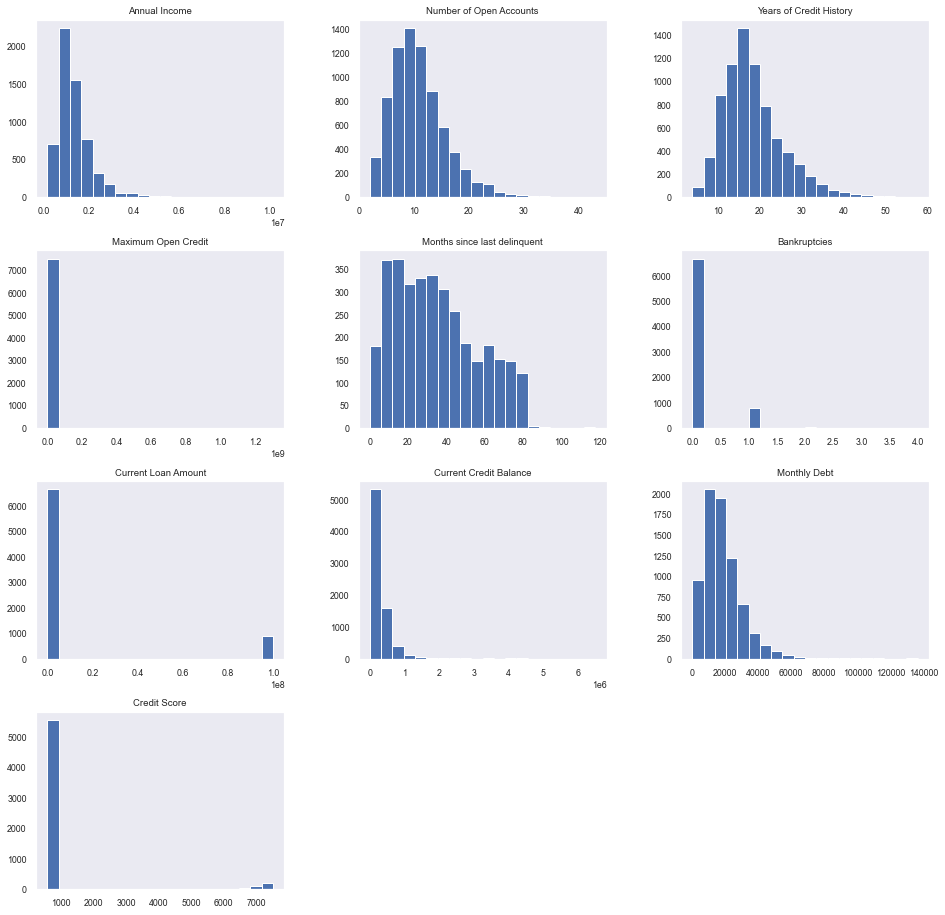

In [143]:
train_df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

Наблюдения:

- Распределения Number of Open Accounts/количество открытых счетов, Years of Credit History/количество лет кредитной истории выгядят абсолютно логично.

Идеи:

- Т.к. пропусков в данных переменных нет, то дополнительно их изучать не требуется.

### Проверим распределения вещественных признаков на трейне и тесте

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


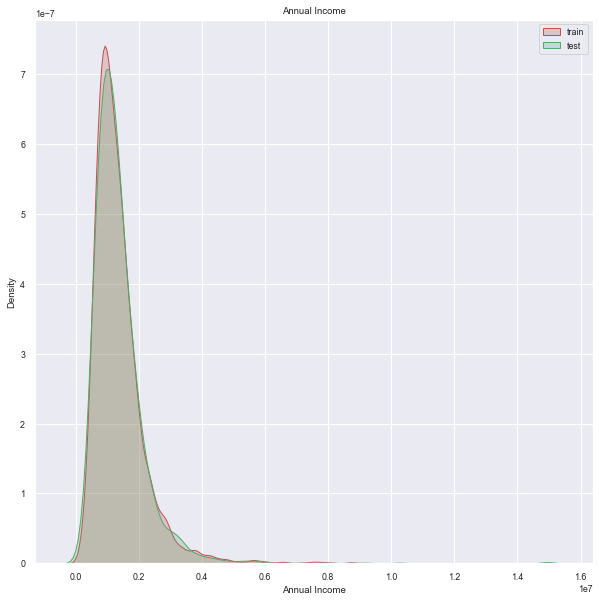

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


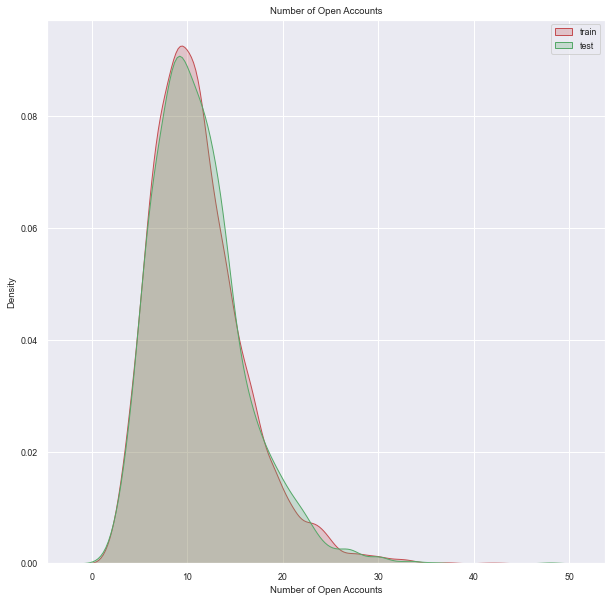

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


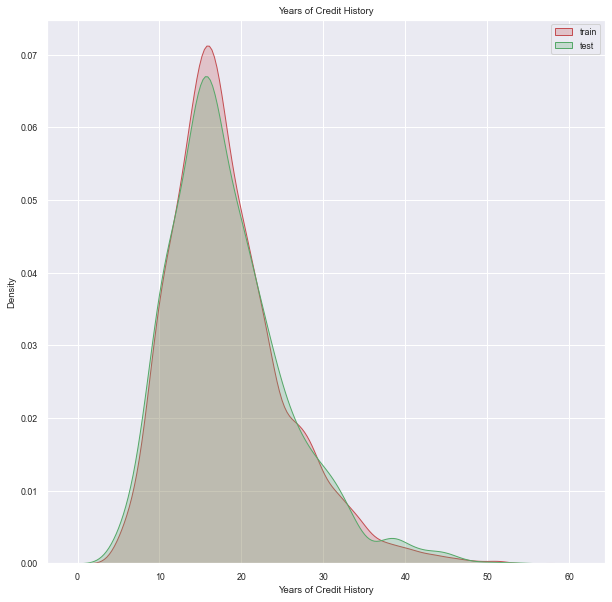

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


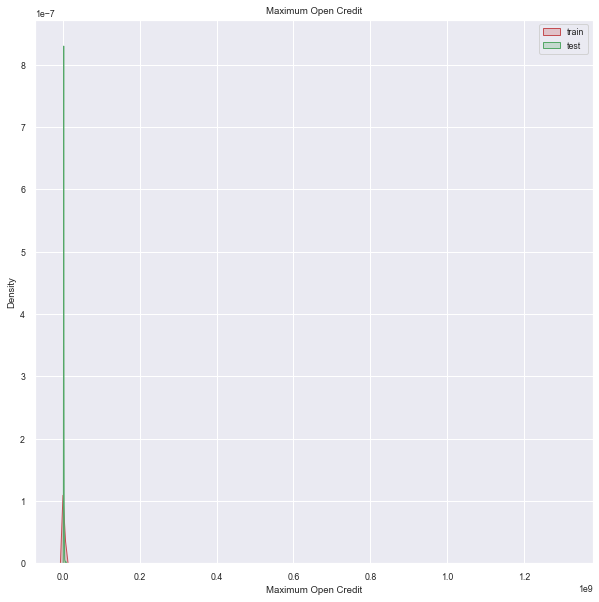

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


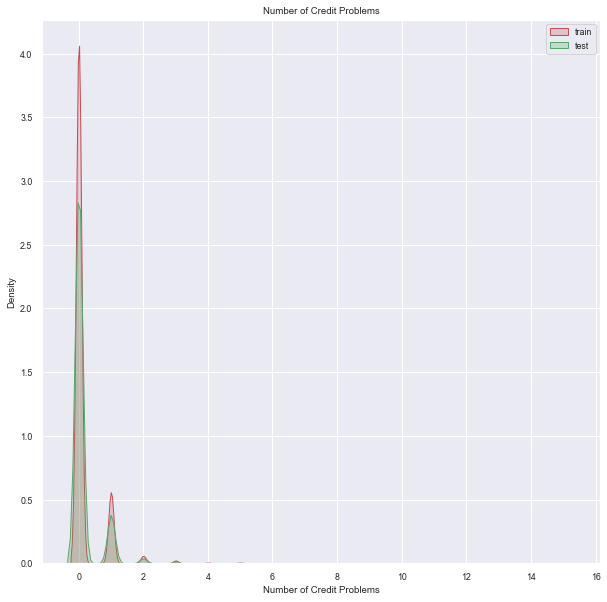

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


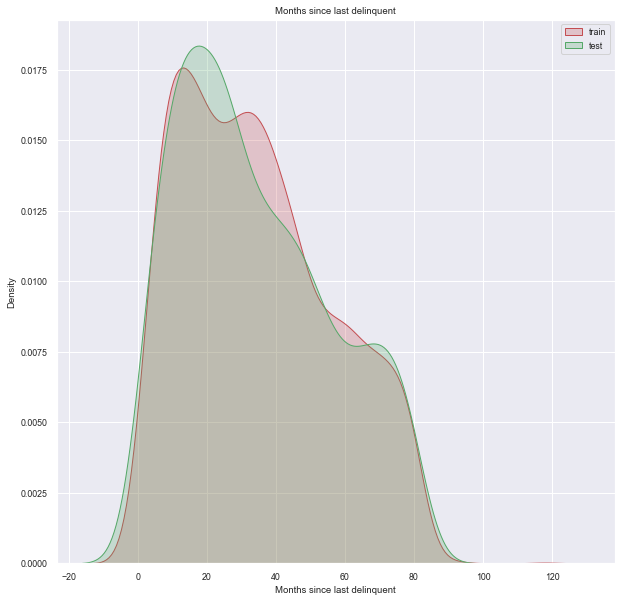

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


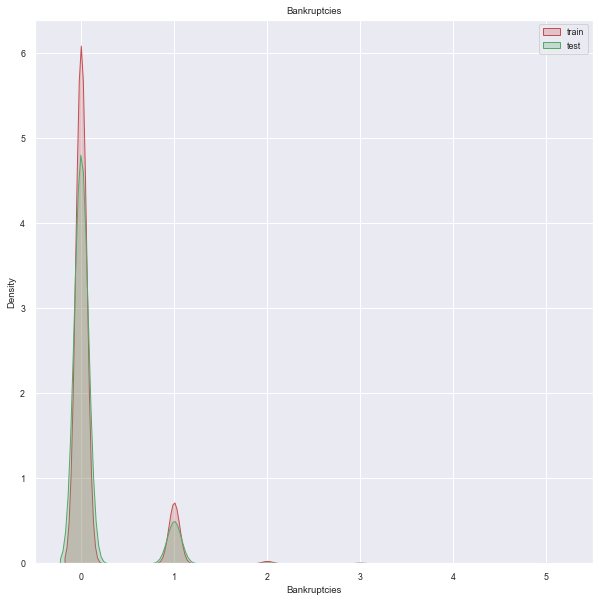

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


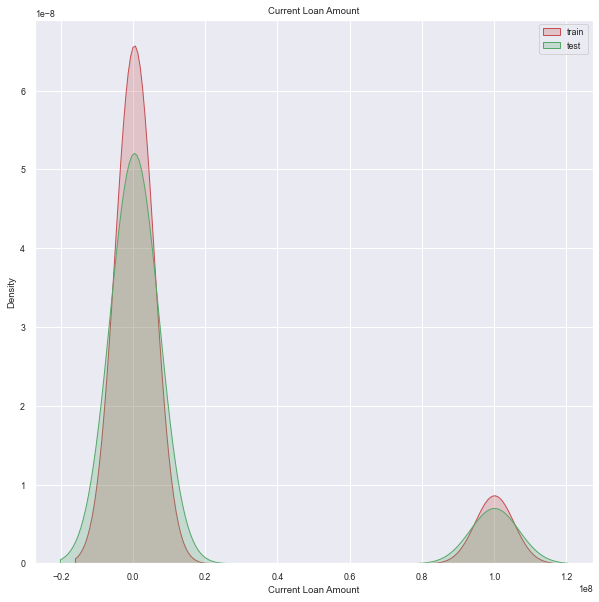

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


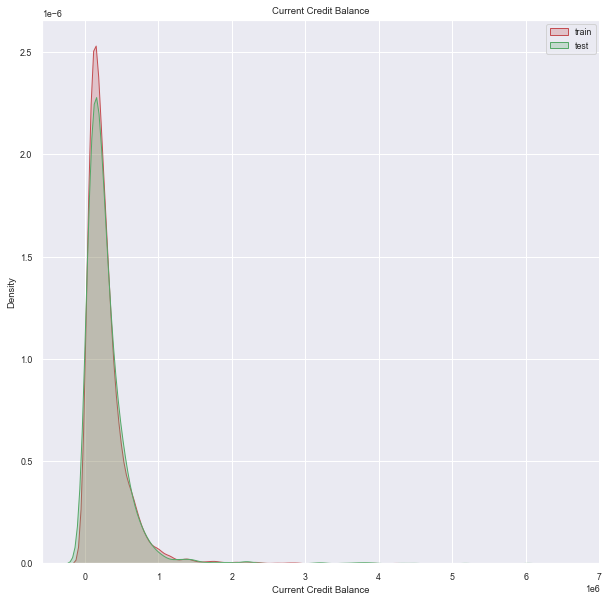

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


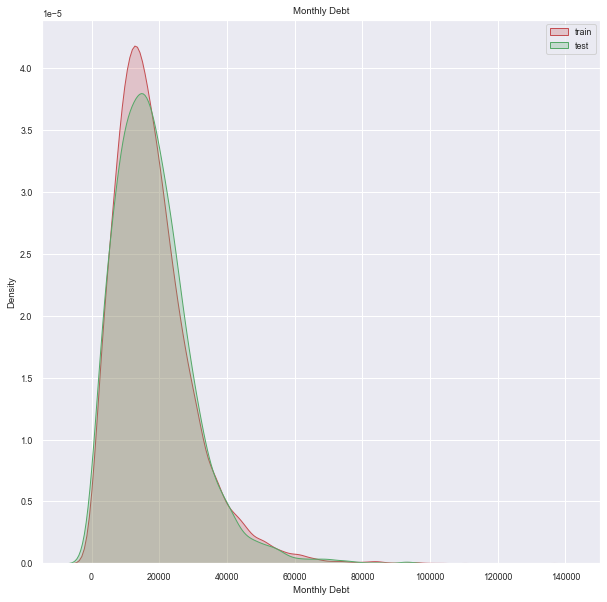

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


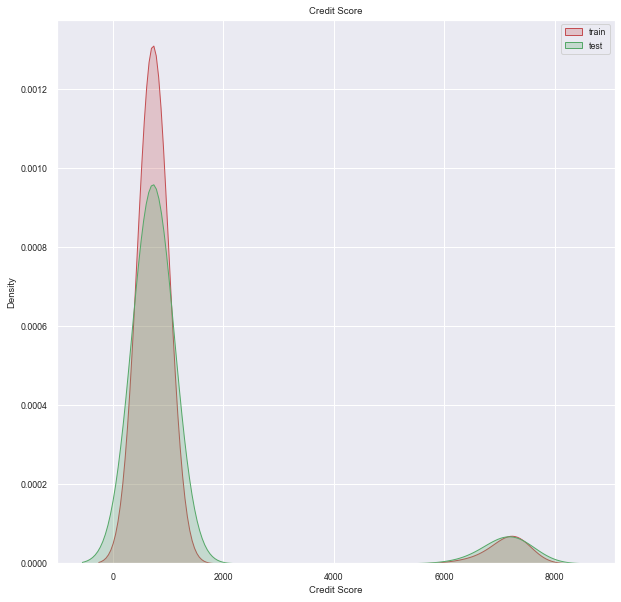

In [129]:
figsize = (10, 10)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train_df[col], shade=True, label='train', color='r')
    sns.kdeplot(test_df[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(train_df[col], test_df[col]))
    plt.legend()
    plt.title(col)
    plt.show()

### Annual Income/годовой доход

In [ ]:
# train_df['Annual Income'].value_counts()

plt.figure(figsize = (16, 8))

train_df['Annual Income'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Annual Income')

plt.title('Annual Income distribution')
plt.show()

Наблюдения:

    - Распределение годового дохода выглядит логично.
    - Наличие хвоста справа объясняется наличием людей, которые много зарабатывают.
Идеи:

    - Ничего не делать.    

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Maximum Open Credit/наибольший открытый кредит

In [ ]:
plt.figure(figsize = (16, 5))

train_df['Maximum Open Credit'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Maximum Open Credit')

plt.title('Maximum Open Credit distribution on TRAIN')
plt.show()

In [ ]:
plt.figure(figsize = (16, 5))

test_df['Maximum Open Credit'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Maximum Open Credit')

plt.title('Maximum Open Credit distribution on TEST')
plt.show()

#### посмотрим распределение Maximum Open Credit если убрать 100 самых больших значений

In [ ]:
plt.figure(figsize = (16, 5))

train_df['Maximum Open Credit'].sort_values()[:-100].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Maximum Open Credit')

plt.title('Maximum Open Credit distribution on TRAIN')
plt.show()

In [ ]:
plt.figure(figsize = (16, 5))

test_df['Maximum Open Credit'].sort_values()[:-100].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Maximum Open Credit')

plt.title('Maximum Open Credit distribution on TEST')
plt.show()

Наблюдения:

    - Видны очень большие значения/выбросы(?) справа, порядка 100 значений или 0.013 от всех значений.
    - Математические ожидания на train и test, как показал выше критерий Манна-Уитни, равны.
Идеи:

    - Заменить 0.013 максимальных значений на NaN, которые потом заполнить при помощи моделей.